# Capstone 3 - Customer Churn Prediction for Telco

In our previous [Notebook](https://github.com/dvanheeswijk/Springboard/blob/master/Capstone_3/Capstone%203%20-%20EDA.ipynb), we explored our data set to find any possible leads to areas to focus on for our modeling. We found that bigger cities had larger churn volumes, while a few cities also had much higher percentages of churn than most others, specifically smaller cities with a handful of customers. We also saw that Fiber Optics customers were almost twice as likely to churn as DSL customers or customers with no internet service. Lastly, we saw that the primary reasons for leaving were basically either competitive offers from other companies or poor service attitude when dealing with troubleshooting issues. 

We will now explore *clean_data.csv*, our preprocessed data set and create training and testing data sets in order to evaluate models.

We start with importing the data and necessary libraries.

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve,scorer
from sklearn.feature_selection import SelectKBest

In [93]:
data = pd.read_csv('data/clean_data.csv')

data.head()

,CustomerID,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,3668-QPYBK,90003,33.964131,-118.272783,0,0,0,0,2,1,...,1,0,0,1,0,0,0,0,0,1
1,9237-HQITU,90005,34.059281,-118.307420,1,0,0,1,2,1,...,0,1,0,1,0,0,0,0,1,0
2,9305-CDSKC,90006,34.048013,-118.293953,1,0,0,1,8,1,...,0,1,0,1,0,0,0,0,1,0
3,7892-POOKP,90010,34.062125,-118.315709,1,0,1,1,28,1,...,0,1,0,1,0,0,0,0,1,0
4,0280-XJGEX,90015,34.039224,-118.266293,0,0,0,1,49,1,...,0,1,0,1,0,0,1,0,0,0


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CustomerID                                7032 non-null   object 
 1   Zip Code                                  7032 non-null   int64  
 2   Latitude                                  7032 non-null   float64
 3   Longitude                                 7032 non-null   float64
 4   Gender                                    7032 non-null   int64  
 5   Senior Citizen                            7032 non-null   int64  
 6   Partner                                   7032 non-null   int64  
 7   Dependents                                7032 non-null   int64  
 8   Tenure Months                             7032 non-null   int64  
 9   Phone Service                             7032 non-null   int64  
 10  Multiple Lines                      

In [95]:
data['CustomerID'].is_unique

True

In [96]:
data.set_index('CustomerID', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Zip Code                                  7032 non-null   int64  
 1   Latitude                                  7032 non-null   float64
 2   Longitude                                 7032 non-null   float64
 3   Gender                                    7032 non-null   int64  
 4   Senior Citizen                            7032 non-null   int64  
 5   Partner                                   7032 non-null   int64  
 6   Dependents                                7032 non-null   int64  
 7   Tenure Months                             7032 non-null   int64  
 8   Phone Service                             7032 non-null   int64  
 9   Multiple Lines                            7032 non-null   int64  
 10  Online Security           

We see now that we have the data in complete numeric format, meaning that we are ready to begin training the data.

### Training the data

In [97]:
# Splitting the data between our dependent and independent variables
X = data.drop(columns='Churn Value')
y = data['Churn Value']

In [98]:
feature_selection = SelectKBest(k=5)
feature_selection.fit(X, y)

cols = feature_selection.get_support(indices=True)
X_new = X.iloc[:,cols]

In [99]:
X_new.head()

,Tenure Months,Internet Service_Fiber optic,Contract_Month-to-month,Contract_Two year,Payment Method_Electronic check
CustomerID,,,,,
3668-QPYBK,2,0,1,0,0
9237-HQITU,2,1,1,0,1
9305-CDSKC,8,1,1,0,1
7892-POOKP,28,1,1,0,1
0280-XJGEX,49,1,1,0,0


In [100]:
X_cols = X_new.columns

In [101]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_new)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=42)

In [102]:
print(X_train.shape, X_test.shape)

(5625, 5) (1407, 5)


In [103]:
print(y_train.shape, y_test.shape)

(5625,) (1407,)


### Creating the models

#### K Means Classifier

In [104]:
param_grid = {'n_neighbors':np.arange(1,50)}

knn = KNeighborsClassifier()

clf = RandomizedSearchCV(knn, param_grid, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_neighbors': 41}

In [105]:
knn = KNeighborsClassifier(n_neighbors=41)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=41)

In [106]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

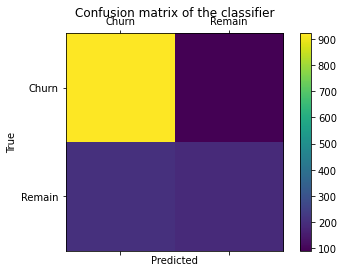

In [107]:
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
# plt.title('Normalized Matrix')
labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [108]:
print(pl)

[[921  91]
 [206 189]]


In [109]:
fn,tp = pl[0][1], pl[0][0]
fnr_kmeans = fn / (tp + fn)
tpr_kmeans = tp / (tp + fn)
fnr_kmeans, tpr_kmeans

(0.08992094861660078, 0.9100790513833992)

In [110]:
auc_kmeans = roc_auc_score(y_test, y_pred)
acc_kmeans = accuracy_score(y_test,y_pred)
print(auc_kmeans, acc_kmeans, fnr_kmeans, tpr_kmeans)

0.6942800320208135 0.7889125799573561 0.08992094861660078 0.9100790513833992


As we can see, this model is alright, but we can likely do better with a different model. 

#### Ridge Classifier

In [111]:
from sklearn.model_selection import RepeatedStratifiedKFold

ridge = RidgeClassifier()

alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = dict(alpha=alphas)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

search = grid.fit(X_train, y_train)

search.best_params_

{'alpha': 0.1}

In [112]:
ridge = RidgeClassifier(alpha=0.1)

ridge.fit(X_train, y_train)

RidgeClassifier(alpha=0.1)

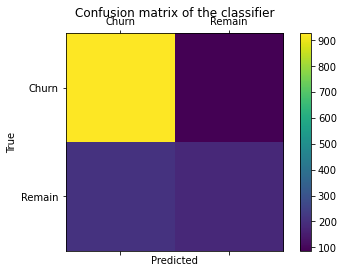

In [113]:
y_pred = ridge.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [114]:
print(pl)

[[925  87]
 [211 184]]


In [115]:
fn,tp = pl[0][1], pl[0][0]
fnr_ridge = fn / (tp + fn)
tpr_ridge = tp / (tp + fn)
fnr_ridge, tpr_ridge

(0.08596837944664032, 0.9140316205533597)

In [116]:
auc_ridge = roc_auc_score(y_test, y_pred)
acc_ridge = accuracy_score(y_test,y_pred)
print(auc_ridge, acc_ridge, fnr_ridge, tpr_ridge)

0.6899272026817431 0.7882018479033405 0.08596837944664032 0.9140316205533597


#### SVC

In [117]:
svc = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=svc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print(grid_result.best_params_)

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


In [118]:
svc = SVC(C=1, gamma='scale', kernel='rbf')

svc.fit(X_train, y_train)

SVC(C=1)

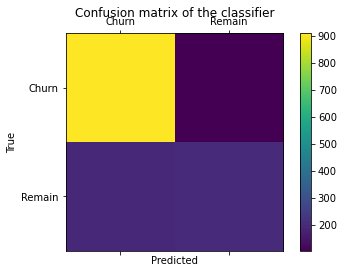

In [119]:
y_pred = svc.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [120]:
print(pl)

[[909 103]
 [197 198]]


In [121]:
fn,tp = pl[0][1], pl[0][0]
fnr_svc = fn / (tp + fn)
tpr_svc = tp / (tp + fn)
fnr_svc, tpr_svc

(0.10177865612648221, 0.8982213438735178)

In [122]:
auc_svc = roc_auc_score(y_test, y_pred)
acc_svc = accuracy_score(y_test,y_pred)
print(auc_svc, acc_svc, fnr_svc, tpr_svc)

0.699743583329164 0.7867803837953091 0.10177865612648221 0.8982213438735178


## Deep learning modeling using Keras

In [123]:
from keras.layers import Dense
from keras.models import Sequential
from IPython.display import SVG
from keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import model_to_dot
from keras import losses
#import pydot
from keras.utils.vis_utils import plot_model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


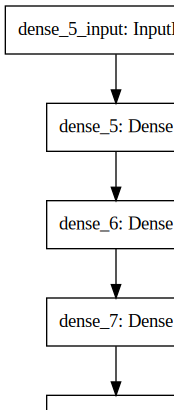

In [124]:
n_cols=X_train.shape[1]
seq = Sequential()
seq.add(Dense(32, input_shape=(n_cols,), activation='relu'))
seq.add(Dense(16, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(4, activation='relu'))
seq.add(Dense(1, activation='sigmoid'))

seq.compile(loss='binary_crossentropy', optimizer='adam')
seq.summary()

#plot the a graph
SVG(model_to_dot(seq).create(prog='dot', format='svg'))

In [125]:
seq.fit(X_train, y_train)
predictions   = seq.predict(X_test)
probabilities = seq.predict_proba(X_test)

seq_roc_auc = roc_auc_score(y_test,predictions) 
print ("Area under curve : ",seq_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)

176/176 [==============================] - 0s 2ms/step - loss: 0.5183
Area under curve :  0.8306474208235353 



In [126]:
import plotly.graph_objects as go
#plot roc curve
trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(seq_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))


In [127]:
import plotly.tools as tls
import plotly as py

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('',
                                            'ROC',
                                            ''))

fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,2)

py.offline.iplot(fig)


C:\Users\david\anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [128]:
acc_sequential = accuracy_score(y_test, predictions.round())

acc_sequential

0.7725657427149965

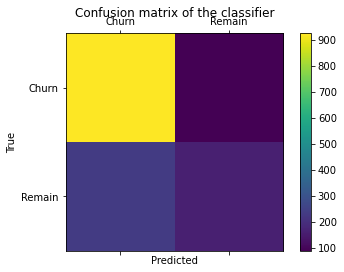

In [129]:
pl = confusion_matrix(y_test,predictions.round())

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
pl

array([[924,  88],
       [232, 163]], dtype=int64)

In [131]:
fn,tp = pl[0][1], pl[0][0]
fnr_seq = fn / (tp + fn)
tpr_seq = tp / (tp + fn)
fnr_seq, tpr_seq

(0.08695652173913043, 0.9130434782608695)

## Conclusions

We have created 4 classification models and will compare the results. First, we look at the table of ROC-AUC scores and accuracy scores to see which are the best at predicting the churn of customers.

In [132]:
scores = pd.DataFrame([['K Means', auc_kmeans, acc_kmeans, fnr_kmeans, tpr_kmeans], 
                       ['Ridge', auc_ridge, acc_ridge, fnr_ridge, tpr_ridge],
                       ['SVC', auc_svc, acc_svc, fnr_svc, tpr_svc],
                       ['Sequential NN', seq_roc_auc, acc_sequential, fnr_seq, tpr_seq]],
                      columns=['Model', 'ROC_AUC_Score', 'Accuracy_Score', 'False Negative Rate', 'True Positive Rate']
            )
scores

,Model,ROC_AUC_Score,Accuracy_Score,False Negative Rate,True Positive Rate
0,K Means,0.694280,0.788913,0.089921,0.910079
1,Ridge,0.689927,0.788202,0.085968,0.914032
2,SVC,0.699744,0.786780,0.101779,0.898221
3,Sequential NN,0.830647,0.772566,0.086957,0.913043


We see in our table of scoring that the Sequential NN has the best ROC_AUC score, but is not necessarily the most accurate. Of the models that are not neural networks, it appears that the KMeans and SVC models work identically well, while the Ridge model is slightly less accurate and has a lower ROC_AUC_Score. We conclude that we should use the Sequential NN or the KMeans models for our final assessments.

In [133]:
ridge.coef_

array([[-0.20184005,  0.20546116,  0.14302479,  0.01090988,  0.10947003]])

In [135]:
ridge.intercept_

array([-0.4737177])

And thus, we have our ridge equation given as:

$y = -0.4737177 - 0.20184005*x_1 + 0.20546116*x_2 + 0.14302479*x_3 + 0.01090988*x_4 + 0.10947003*x_5$

Where 
* $x_1$ = 'Tenure in Months', 
* $x_2$ = 'Fiber Optics customers', 
* $x_3$ = 'Month-to-Month contracts', 
* $x_4$ = '2-year contracts', 
* $x_5$ = 'Electronic Check Payments'

In [42]:
from sklearn.model_selection import cross_val_score, cross_validate

models = [knn, ridge, svc]

for m in models:
    cv_res = cross_val_score(m, X, y, scoring='accuracy', cv = 10)
    print(str(m) + ': '+ str(cv_res.mean()))

KNeighborsClassifier(n_neighbors=41): 0.729663253265227
RidgeClassifier(alpha=0.1): 0.8040386977886979
SVC(C=1): 0.7342149715504978


KNeighborsClassifier(n_neighbors=41): 0.678946 (0.377039)
RidgeClassifier(alpha=0.1): 0.727661 (0.243176)
SVC(C=1): 0.734424 (0.415297)


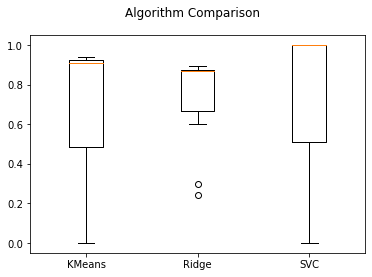

In [43]:
from sklearn import model_selection
results = []
names = ['KMeans', 'Ridge', 'SVC']

for m in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(m, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (str(m), cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [44]:
cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.19616205, -0.18123667, -0.20981508, -0.19345661, -0.19772404])

In [45]:
cv_results = cross_validate(svc, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.26581379, -0.26581379, -0.26600284, -0.26600284, -0.26529161])

In [46]:
cv_results = cross_validate(knn, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
cv_results['test_score']

array([-0.26297086, -0.27789623, -0.26315789, -0.27382646, -0.26742532])

In [47]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
seq.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

history = seq.fit(X_train, y_train, validation_split=0.3, epochs=10, verbose=0)

loss, accuracy, f1_score, precision, recall = seq.evaluate(X_test, y_test, verbose=0)

In [49]:
print(loss, accuracy, f1_score, precision, recall)

0.43621209263801575 0.7938876748085022 0.5782781839370728 0.6754469275474548 0.5384647846221924


In [50]:
# Save the best model in best_model
best_model = ridge

## Model evaluation

To make one comparison between our best model, the Ridge Classifier with alpha=0.1, we will first compare it to a dummy classifier and compare the results.

In [51]:
from sklearn.dummy import DummyClassifier

In [52]:
dummy = DummyClassifier()

C:\Users\david\anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



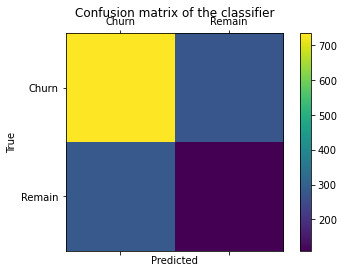

In [53]:
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
print(pl)

[[734 278]
 [285 110]]


In [55]:
fn,tp = pl[0][1], pl[0][0]
fnr_dummy = fn / (tp + fn)
tpr_dummy = tp / (tp + fn)
fnr_dummy, tpr_dummy

(0.274703557312253, 0.7252964426877471)

In [56]:
print("Dummy TPR: " + str(tpr_dummy))
print("Ridge TPR: " + str(tpr_ridge))

Dummy TPR: 0.7252964426877471
Ridge TPR: 0.9140316205533597


Business rule 1: Any customer with less than 17 months tenure is likely to churn.

In [57]:
inversed = scaler.inverse_transform(X_test)

In [58]:
rules = inversed
rules = pd.DataFrame(rules, columns=X_cols)
rules.head()

,Tenure Months,Internet Service_Fiber optic,Contract_Month-to-month,Contract_Two year,Payment Method_Electronic check
0,42.0,0.0,0.0,1.000000e+00,1.0
1,43.0,0.0,0.0,-2.775558e-17,1.0
2,27.0,1.0,1.0,-2.775558e-17,1.0
3,65.0,0.0,0.0,1.000000e+00,0.0
4,29.0,0.0,0.0,-2.775558e-17,0.0


In [60]:
rules['Rule_1'] = 0
rules.loc[rules['Tenure Months'] < 17,'Rule_1'] = 1
rules['Rule_1'].unique()

array([0, 1], dtype=int64)

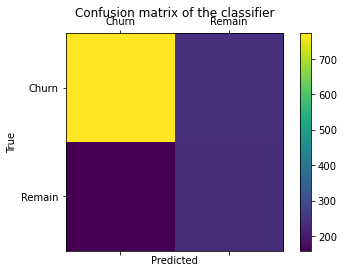

In [61]:
pl = confusion_matrix(y_test,rules['Rule_1'])

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
print(pl)

fn,tp = pl[0][1], pl[0][0]
fnr_rule_1 = fn / (tp + fn)
tpr_rule_1 = tp / (tp + fn)
print(tpr_rule_1)

[[772 240]
 [158 237]]
0.7628458498023716


Business rule 2: Any customer with month to month contracts are marked as churning.

In [63]:
rules['Rule_2'] = 0
rules.loc[rules['Contract_Month-to-month'] == 1,'Rule_2'] = 1
rules['Rule_2'].unique()

array([0, 1], dtype=int64)

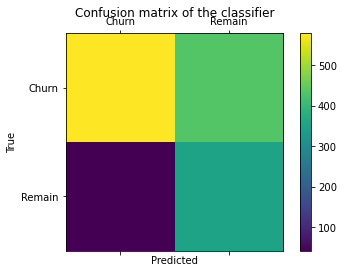

In [64]:
pl = confusion_matrix(y_test,rules['Rule_2'])

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [65]:
print(pl)

fn,tp = pl[0][1], pl[0][0]
fnr_rule_2 = fn / (tp + fn)
tpr_rule_2 = tp / (tp + fn)
print(tpr_rule_2)

[[578 434]
 [ 42 353]]
0.5711462450592886


Business Rule 3: Customers with Fiber Optics and Month to Month Contracts will churn.

In [66]:
rules['Rule_3'] = 0
rules.loc[(rules['Internet Service_Fiber optic'] == 1)&(rules['Contract_Month-to-month'] == 1), 'Rule_3'] = 1
# rules.loc[] = 1
rules['Rule_3'].unique()

array([0, 1], dtype=int64)

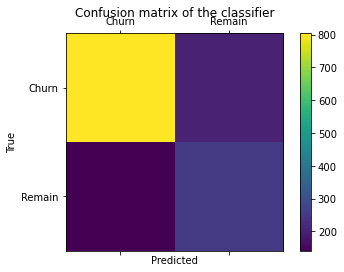

In [67]:
pl = confusion_matrix(y_test,rules['Rule_3'])

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
print(pl)

fn,tp = pl[0][1], pl[0][0]
fnr_rule_3 = fn / (tp + fn)
tpr_rule_3 = tp / (tp + fn)
print(tpr_rule_3)

[[804 208]
 [141 254]]
0.7944664031620553


In [69]:
business_scores = pd.DataFrame([ 
                       ['Ridge', tpr_ridge],
                       ['Rule 1', tpr_rule_1],
                       ['Rule 2', tpr_rule_2],
                       ['Rule 3', tpr_rule_3]],
                      columns=['Model/Business Criteria', 'True Positive Rate']
            )
business_scores

,Model/Business Criteria,True Positive Rate
0,Ridge,0.914032
1,Rule 1,0.762846
2,Rule 2,0.571146
3,Rule 3,0.794466


In [84]:
from sklearn.tree import DecisionTreeClassifier

In [88]:
model = DecisionTreeClassifier()
max_depth = [5,6,7]
criterion = ['gini', 'entropy']
max_features = ['int', 'float',"auto", "sqrt", "log2"]
# define grid search
grid = dict(criterion=criterion, max_depth=max_depth, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.792297 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2'}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'int'}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'float'}
0.791171 (0.013090) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto'}
0.791289 (0.010493) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.789628 (0.018130) with: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'int'}
0.000000 (0.000000) with: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'float'}
0.791231 (0.012927) with: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto'}
0.789511 (0.014269) with: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt'}
0.790993 (0.014313) with: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2'}
0.000000 (0.000000) with: {'criter

In [89]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='log2')

tree.fit(X_train,y_train)

t_pred = tree.predict(X_test)

confusion_matrix(t_pred, y_test)

array([[922, 200],
       [ 90, 195]], dtype=int64)

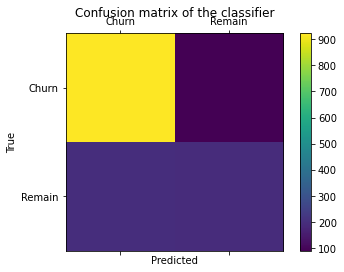

In [90]:
pl = confusion_matrix(y_test,t_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [91]:
print(pl)

fn,tp = pl[0][1], pl[0][0]
fnr_rule_3 = fn / (tp + fn)
tpr_rule_3 = tp / (tp + fn)
print(tpr_rule_3)

[[922  90]
 [200 195]]
0.9110671936758893


##### Using Featuretools for feature engineering

In [ ]:
import featuretools as ft

In [ ]:
demo = pd.read_excel('data/Telco_customer_churn_demographics.xlsx')
loc = pd.read_excel('data/Telco_customer_churn_location.xlsx')
# pop = pd.read_excel('data/Telco_customer_churn_population.xlsx')
serv = pd.read_excel('data/Telco_customer_churn_services.xlsx')
status = pd.read_excel('data/Telco_customer_churn_status.xlsx')

In [ ]:
es = ft.EntitySet(id='customers')

In [ ]:
demo.drop(columns='Count', inplace=True)
demo.head()

In [ ]:
import featuretools.variable_types as vtypes

In [ ]:
es.entity_from_dataframe(entity_id='demographics', dataframe=demo,
                         index = 'Customer ID', 
                         variable_types = {'Gender': vtypes.Categorical, 
                                           'Under 30': vtypes.Boolean,
                                          'Senior Citizen': vtypes.Boolean,
                                          'Married': vtypes.Boolean,
                                          'Dependents': vtypes.Boolean})

In [ ]:
loc.drop(columns=['Country', 'State', 'Count'], inplace=True)

In [ ]:
loc.head()

In [ ]:
es.entity_from_dataframe(entity_id='location', dataframe=loc,
                         index = 'Customer ID', 
                         variable_types = {'City': vtypes.Categorical,
                                           'Lat Long': vtypes.Categorical,
                                          'Zip Code': vtypes.Categorical})

In [ ]:
serv.drop(columns=['Count', 'Quarter'], inplace=True)
serv.head()

In [ ]:
serv.columns

In [ ]:
serv['Paperless Billing'].unique()

In [ ]:
es.entity_from_dataframe(entity_id='services', dataframe=serv,
                         index = 'Customer ID', 
                         variable_types = {'Referred a Friend': vtypes.Boolean,
                                           'Offer': vtypes.Categorical,
                                          'Phone Service': vtypes.Boolean,
                                          'Multiple Lines': vtypes.Boolean,
                                          'Internet Service': vtypes.Boolean,
                                          'Internet Type': vtypes.Categorical,
                                          'Online Security': vtypes.Boolean,
                                          'Online Backup': vtypes.Boolean,
                                          'Device Protection Plan': vtypes.Boolean,
                                          'Premium Tech Support': vtypes.Boolean,
                                          'Streaming TV': vtypes.Boolean,
                                           'Streaming Movies': vtypes.Boolean,
                                           'Streaming Music': vtypes.Boolean,
                                           'Unlimited Data': vtypes.Boolean, 
                                           'Paperless Billing': vtypes.Boolean,
                                          'Contract': vtypes.Categorical,
                                          'Payment Method': vtypes.Categorical})

In [ ]:
status.drop(columns=['Count', 'Quarter', 'Customer Status', 'Churn Label', 'Churn Category', 'Churn Reason'], inplace=True)
status.head()

In [ ]:
status.drop(columns='Churn Score', inplace=True)

In [ ]:
es.entity_from_dataframe(entity_id='status', dataframe=status,
                         index = 'Customer ID', 
                         variable_types = {'Churn Value': vtypes.Boolean
                                           })

In [ ]:
r_customer_demos = ft.Relationship(es['status']['Customer ID'], es['demographics']['Customer ID'])
r_customer_services = ft.Relationship(es['status']['Customer ID'], es['services']['Customer ID'])
r_customer_loc = ft.Relationship(es['status']['Customer ID'], es['location']['Customer ID'])

es.add_relationships([r_customer_services, r_customer_demos, r_customer_loc])

In [ ]:
feature_defs = ft.dfs(entityset=es, target_entity='status["Churn Value"]', where_primitives = ['sum', 'mean', 'max', 'min'],
                      max_depth=3, features_only=True)

In [ ]:
print(f'This will generate {len(feature_defs)} features.')